## __재분석의 필요성__

학과에서 진행된 학회 포스터의 발표를 준비하는 과정에서, 제 코드 리뷰와 함께 다른 팀의 코드 리뷰를 진행하였습니다.

이 과정에서 다른 팀이 1. __범주형 변수인 건물번호를 기준으로 60개 모델을 생성__ 하여 분석을 진행한 접근법이 매우 유용하다고 느꼈습니다. 이 아이디어를 바탕으로 분석을 진행하면 더 나은 예측 성능을 얻을 수 있을 것이라고 판단하였습니다.

또한, 제 기존 분석에서 2. __시계열 데이터의 특성을 충분히 반영하지 않았다__ 는 문제점을 발견하였습니다. 시계열 데이터를 사용했음에도 불구하고, 시간의 흐름에 따른 변화를 고려한 모델링이 이루어지지 않았다는 점이 문제였고, 이를 보완하기 위해 재분석을 시도하게 되었습니다.

그 외에도, 3. 후처리 과정을 통해 예측 성능을 평가하고, 예측의 정확도를 확인하고자 하였습니다. 기존 분석에서는 후처리 과정이 부족해 예측 정확도를 충분히 평가하지 못했던 부분이 있었고, 이를 개선하기 위해 더 나은 후처리 절차를 추가하려고합니다.

이와 같은 문제들을 해결하고 성능을 향상시킬 수 있는 방법을 제시하기 위해 재분석을 진행하게 되었습니다.

## __재분석을 위한 접근 방법__

이 분석에서 건물번호를 기준으로 60개 모델을 생성할 경우, 기존에 건물번호를 기준으로 군집화한 변수는 어떻게 처리해야할지에 대한 문제가 발생합니다. 이에 대해 두 가지 방법을 고려하였습니다.

__방법 1__: 군집화로 유사한 건물번호들을 그룹화한 후, 그룹을 별도의 모델로 분석한다.

    장점:
        * 방법 2에 비해 모델 수가 적어지므로 훈련시간이 빠르다.
        * 그룹 내에서 유사한 특성을 가진 건물들끼리 예측을 진행하므로, 모델의 성능을 개선할 수 있다.
          
    단점:
        * 군집화로 인한 정보손실이 발생할 수 있다.
        * 초기 군집수 설정에 따라 결과가 달라질 수 있다.

__방법 2__: 군집화 변수를 제외하고 건물번호를 기준으로 60개의 모델을 생성한다.

    장점:
        * 각 건물번호에 독립적인 모델을 생성하므로, 개별 모델의 예측 정확도가 향상될 수 있다.
        * 군집화 없이 각 건물번호에 최적화된 모델을 만들어 세밀한 예측이 가능하다.
    
    단점:
        * 모델 수가 60개로 많아져 과적합 문제가 발생할 수 있다.
        * 모델의 수가 많아져 훈련시간이 많이 소모된다.

두 가지 방법을 모두 사용하여 분석을 진행하였고, 가장 좋은 접근 방안을 도출하고자 하였습니다.

## __새로운 분석 시도__

### __데이터불러오기__

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import warnings
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [2]:
with open('train_test_data.pkl', 'rb') as f:
    train, test = pickle.load(f)

submission = pd.read_csv('../data/sample_submission.csv', encoding='cp949')

### __시계열을 고려한 추가 코드__

In [3]:
# 주기성을 반영하고자 sinm cos변환을 사용하여 시간정보를 주기적인 방식으로 모델에 제공
train['sin_hour'] = np.sin(2*np.pi*train.hour_by_3/8)
train['cos_hour'] = np.cos(2*np.pi*train.hour_by_3/8) 

test['sin_hour'] = np.sin(2*np.pi*test.hour_by_3/8)
test['cos_hour'] = np.cos(2*np.pi*test.hour_by_3/8) 

#### __모델에 맞게 데이터 설정__

시계열 데이터를 고려하여 __교차 검증 방식으로__ train_test_split 대신 __Time Series split K-fold__ 방법을 적용하였습니다.

Time Series split K-fold는 앞에 있는 데이터를 train, 뒤에 있는 데이터를 test로 두기에 데이터가 시간 순서대로 정렬되어 있어야합니다.

방법2에서는 각 모델을 생성할 때, 데이터가 시간 순서대로 정렬 되어 있어 바로 적용할 수 있지만,

방법1에서는 군집별로 모델을 생성하게 되면, 군집별로 정렬되어 있어 별도의 정렬을 진행 하였습니다.

시간 순으로 데이터 정렬(방법1에 사용할 모델)

In [4]:
x_train_method1 = train.copy()
y_train_method1 = train['power'].copy()
x_test_method1 = test.copy()

x_train_method1 = x_train_method1.sort_values(['date_time','num'])
x_test_method1.sort_values(['date_time','num'])

y_train_method1 = y_train_method1[x_train_method1.index].reset_index(drop=True)
x_train_method1 = x_train_method1.reset_index(drop=True)
x_test_method1 = x_test_method1.reset_index(drop=True)


x_train_method1 = x_train_method1.drop(['date_time','power','hour_by_3'], axis = 1, inplace = False)
x_test_method1 = x_test_method1.drop(['date_time','hour_by_3'], axis = 1, inplace = False)

방법 2에 사용할 모델

건물별로 모델을 만들경우 비전기냉방설비운영(non_elec), 태양광보유여부(solar)변수가 모두 동일하므로 분석에서 제외한다.

In [5]:
x_train = train.copy()
y_train = train['power'].copy()
x_test = test.copy()
x_train = x_train.drop(['date_time','power','hour_by_3', 'non_elec', 'solar'], axis = 1, inplace = False)

x_test = x_test.drop(['date_time', 'hour_by_3', 'non_elec', 'solar'], axis = 1, inplace = False)

### __모델__

In [6]:
def SMAPE(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred)
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0  # 분모가 0인 경우는 제외
    return 200 * np.mean(diff)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split

#### __방법 1에 의한 모델 생성__

교차검증

In [8]:
method1_rmse_scores = []
method1_smape_scores = []
method1_cluster_sizes  = []

for cluster in range(0,4):
    x_train_cluster = x_train_method1.loc[x_train_method1.cluster == cluster].drop(['cluster'],axis=1,inplace=False)
    y_train_cluster = y_train_method1[x_train_method1.cluster == cluster]

    cluster_size = x_train_cluster.shape[0]  # x_train_cluster의 행 수 (즉, 데이터 포인트 수)
    method1_cluster_sizes.append(cluster_size)  # 군집별 데이터 수 리스트에 추가
    unique_num = len(x_train_cluster.num.unique())

    y_train_c, y_test_c, x_train_c, x_test_c = temporal_train_test_split(y = y_train_cluster,
                                                                          X = x_train_cluster, test_size = 24 * 7 * unique_num)
    
    lgbm = LGBMRegressor(n_estimators = 1000, max_depth = 10, min_child_samples = 10,
                         learning_rate = 0.01, subsample = 0.8, random_state=10, verbose=0)

    lgbm.fit(x_train_c, y_train_c)
    
    pred = lgbm.predict(x_test_c)

    clustering = 'clustering ' + str(cluster)    
    print(clustering)

    mse = mean_squared_error(y_test_c, pred)
    rmse_score = np.sqrt(mse)
    method1_rmse_scores.append(rmse_score)

    print('평균 RMSE: ', np.mean(method1_rmse_scores[-1]))

    smape_score = SMAPE(y_test_c, pred)
    method1_smape_scores.append(smape_score)
    
    print('평균 SMAPE: ', np.mean(method1_smape_scores[-1]))

clustering 0
평균 RMSE:  140.1785908625381
평균 SMAPE:  3.2276370196894657
clustering 1
평균 RMSE:  334.4914556745269
평균 SMAPE:  8.724012310262443
clustering 2
평균 RMSE:  266.1299245485915
평균 SMAPE:  10.397231346882425
clustering 3
평균 RMSE:  256.676523623985
평균 SMAPE:  7.472882010314505


모델 생성 및 제출

In [9]:
models_1 = {}

preds_1 = []

all_preds_1 = pd.DataFrame()

file_path = 'models/model_method1.pkl'
if not os.path.exists('models'):
    os.makedirs('models')


for cluster in range(0,4):
    x_train_cluster = x_train_method1.loc[x_train_method1.cluster == cluster].drop(['cluster'],axis=1,inplace=False)
    y_train_cluster = y_train_method1[x_train_method1.cluster == cluster]
    x_test_cluster = x_test_method1.loc[x_test_method1.cluster == cluster].drop(['cluster'],axis=1,inplace=False)
    
       
    lgbm = LGBMRegressor(n_estimators = 1000, max_depth = 30, min_child_samples = 100,
                             learning_rate = 0.01, subsample = 0.8, random_state=10, verbose=0)
        
    lgbm.fit(x_train_cluster, y_train_cluster)
    
    models_1[cluster] = lgbm
        
    pred = lgbm.predict(x_test_cluster)
    
    cluster_preds = pd.DataFrame({'id': x_test_cluster.index, 'pred': pred})
    all_preds_1 = pd.concat([all_preds_1, cluster_preds])
    
        # 예측값을 리스트에 추가 (나중에 하나의 배열로 합칠 때 사용)
    preds_1.append(pred)
    
all_preds_1 = all_preds_1.set_index('id')
    
    # 인덱스 정렬
all_preds_1 = all_preds_1.sort_index()

with open('models/model_method1.pkl', 'wb') as f:
    pickle.dump(models_1, f)

In [10]:
submission['answer'] = all_preds_1
submission.to_csv('submission_method1.csv', index=False)

#### __방법2에 의한 모델 생성__

모델 검증

In [11]:
method2_rmse_scores = []
method2_smape_scores = []

for num in np.arange(1, 61):    
    x_train_num = x_train.loc[x_train.num == num].drop(['num','cluster'],axis=1,inplace=False)
    y_train_num = y_train[x_train.num == num]

    y_train_n, y_test_n, x_train_n, x_test_n = temporal_train_test_split(y = y_train_num,
                                                                          X = x_train_num, test_size = 24*7)

    lgbm = LGBMRegressor(n_estimators = 1000, max_depth = 100, min_child_samples = 10,
                         learning_rate = 0.01, subsample = 0.8, random_state=10, verbose=0)
    lgbm.fit(x_train_n, y_train_n)

    pred = lgbm.predict(x_test_n)

    building = 'building '+str(num)     
    print(building)

    mse = mean_squared_error(y_test_n, pred)
    rmse_score = np.sqrt(mse)
    method2_rmse_scores.append(rmse_score)

    print('평균 RMSE: ', np.mean(method2_rmse_scores[-1]))

    smape_score = SMAPE(y_test_n, pred)
    method2_smape_scores.append(smape_score)
    
    print('평균 SMAPE: ', np.mean(method2_smape_scores[-1]))

building 1
평균 RMSE:  55.27068075256691
평균 SMAPE:  0.5725672004250322
building 2
평균 RMSE:  100.27360564500363
평균 SMAPE:  4.416259991238649
building 3
평균 RMSE:  157.64693563502226
평균 SMAPE:  3.2896887485017787
building 4
평균 RMSE:  339.80584573557024
평균 SMAPE:  19.692699338778734
building 5
평균 RMSE:  283.60343212882634
평균 SMAPE:  7.5290677853617245
building 6
평균 RMSE:  127.28609404683095
평균 SMAPE:  6.052462139376592
building 7
평균 RMSE:  228.6483789478511
평균 SMAPE:  8.368215056748902
building 8
평균 RMSE:  1004.5654469046324
평균 SMAPE:  8.963241178438414
building 9
평균 RMSE:  63.85277049314124
평균 SMAPE:  4.443216238611568
building 10
평균 RMSE:  213.1925446081252
평균 SMAPE:  8.871499381255827
building 11
평균 RMSE:  208.02700223974801
평균 SMAPE:  5.4537606486459005
building 12
평균 RMSE:  171.08858341680846
평균 SMAPE:  5.8081285402093865
building 13
평균 RMSE:  70.86073265636462
평균 SMAPE:  4.239263611011047
building 14
평균 RMSE:  78.2572456711502
평균 SMAPE:  2.9713922754635163
building 15
평균 RMSE:  210.247

모델 생성 및 제출

In [12]:
models_2 = {}

preds_2 = []

all_preds_2 = pd.DataFrame()

file_path = 'models/model_method2.pkl'
if not os.path.exists('models'):
    os.makedirs('models')

for num in np.arange(1,61):
    x_train_num = x_train.loc[x_train.num == num].drop(['num','cluster'],axis=1,inplace=False)
    y_train_num = y_train[x_train.num == num]
    x_test_num = x_test.loc[x_test.num == num].drop(['num', 'cluster'], axis=1, inplace=False)
    
    lgbm = LGBMRegressor(n_estimators = 1000, max_depth = 100, min_child_samples = 10,
                         learning_rate = 0.01, subsample = 0.8, random_state=10, verbose=0)
    lgbm.fit(x_train_num, y_train_num)

    models_2[num] = lgbm
    
    pred = lgbm.predict(x_test_num)

    num_preds = pd.DataFrame({'id': x_test_num.index, 'pred': pred})
    all_preds_2 = pd.concat([all_preds_2, num_preds])

    preds_2.append(pred)

all_preds_2 = all_preds_2.set_index('id')
all_preds_2 = all_preds_2.sort_index()

with open('models/model_method2.pkl', 'wb') as f:
    pickle.dump(models_2, f)

In [13]:
submission['answer'] = all_preds_2
submission.to_csv('submission_method2.csv', index=False)

## __결과 해석__

### __모델 성능 분석__

기존 모델(전체 데이터를 학습)의 경우,
간단하고 모델이 단일화 되어 __해석이 쉽고, 예측속도가 빠르다는 장점이__ 있지만, __과적합의 위험__ 이 있고, __건물번호와 같은 중요한 변수의 특성을 잘 반영하지 못해 특정 범수에 대해 정확도가 떨어질__ 가능성이 있습니다.

방법1(군집화를 통한 그룹별 모델을 생성)의 경우, __군집의 특성을 반영할 수 있어 군집 내의 패턴을 더 잘 반영하여__ 정확한 예측이 가능하지만, __군집화가 잘못 되었을 경우 예측 정확도가 낮아질__ 수 있습니다.

방법2(건물별로 모델을 생성)의 경우, 건물번호와 같은 중요한 범주에 따라 모델을 학습시키므로, __각 건물의 특성에 맞는 예측이 가능하고, 맞춤형 예측이 가능해져 예측 정확도가 높을 수 있습니다.__ 그러나, __60개의 모델을 실행해야하므로 예측속도가 낮고, 모델의 관리가 복잡하다__ 는 단점이 존재합니다.

이를 수치적으로 비교하기 위해, 모델의 성능을 평가하는 SMAPE를 사용하여 각 모델의 성능을 비교하였습니다.

두 방법의 경우 모델의 수가 각각 4개와 60개이기 때문에 SMAPE값의 평균을 내어 비교하였습니다.

하지만, __방법1__ 의 경우 __군집별 데이터수가 다르기 때문에__, 모델별 __SMAPE값을 단순 평균내기 보다는 데이터 수를 고려하여 가중치를 부여한 가중평균 SMAPE__ 를 계산하였습니다.

가중평균 SMAPE는 다음과 같이 계산됩니다:

$가중평균 SMAPE= 
∑(군집별 SMAPE×군집별 데이터 수)/
∑군집별 데이터 수
$

__방법2__ 의 건물별 모델 생성에서는 각 건물의 데이터의 수가 동일하므로 단순 평균을 계산하여 비교하였습니다..

#### 기존 모델의 SMAPE

In [14]:
base_smape_scores = 8.337461537620431

#### 방법1의 가중SMAPE

In [15]:
method1_smape_scores = np.array(method1_smape_scores)
method1_cluster_sizes = np.array(method1_cluster_sizes)

numerator = np.sum(method1_smape_scores * method1_cluster_sizes)
denominator = np.sum(method1_cluster_sizes)
method1_weighted_average_smape = numerator / denominator

method1_weighted_average_smape

7.3972829152292885

#### 방법2의 SMAPE

In [16]:
method2_average_smape = np.mean(method2_smape_scores)
method2_average_smape

6.437506806061974

__SMAPE의 경우 0에 가까울수록 예측성능이 더 우수하므로, 기존모델 < 방법 1 < 방법2 순으로 예측성능이 좋았습니다.__

방법 2의 성능을 더 높이기 위해, __모델 수가 세분화 됨에 따라, 각 모델에 할당 된 데이터 수가 작아져 예측 정확도가 떨어질 수 있다는 가설__ 을 세우게 되었습니다. 데이터 수가 적어지면 각 모델이 충분히 학습하지 못해 성능이 예상보다 저조할 수 있습니다.

이 문제를 해결하기 위해 __XGBoost__ 라는 다른 모델링 기법을 사용하여 성능을 다시 예측하고자 하였습니다. XGBoost는 상대적으로 작은 데이터셋에서도 성능을 잘 유지할 수 있으며, __과적합을 방지하면서 더 나은 예측 성능을 기대할 수 있습니다.__ 이를 통해 각 모델이 더 적절하게 학습하고, 예측 성능을 개선할 수 있을 것으로 예상됩니다.

#### 추가 모델링(XGBoost 적용)

xgboost 모델의 경우 범주형 데이터 타입을 처리하지 않아, 범주형 변수의 처리가 필요합니다.

원 - 핫 인코딩

In [17]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ['holiday']
encoder = OneHotEncoder(drop = 'first', sparse_output = False)  # drop='first'로 첫 번째 범주를 삭제하여 다중공선성 방지

x_train_encoded = encoder.fit_transform(x_train[categorical_columns])
x_train_encoded_df = pd.DataFrame(x_train_encoded, columns=encoder.get_feature_names_out(categorical_columns))

x_train_final = pd.concat([x_train.drop(columns=categorical_columns), x_train_encoded_df], axis=1)

In [18]:
import xgboost as xgb

method2_xgb_rmse_scores = []
method2_xgb_smape_scores = []

for num in np.arange(1, 61):    
    x_train_num = x_train_final.loc[x_train_final.num == num].drop(['num','cluster'],axis=1,inplace=False)
    y_train_num = y_train[x_train.num == num]

    y_train_n, y_test_n, x_train_n, x_test_n = temporal_train_test_split(y = y_train_num,
                                                                          X = x_train_num, test_size = 24*7)

    xgboost = xgb.XGBRegressor(n_estimators=1000, max_depth=5, learning_rate=0.01, min_child_weight=3,
                               subsample=0.8, random_state=10, verbosity=0) # 학습 시간이 오래 걸려 depth의 크기를 조정

    xgboost.fit(x_train_n, y_train_n)
   
    pred = xgboost.predict(x_test_n)

    building = 'building '+str(num)     
    print(building)

    mse = mean_squared_error(y_test_n, pred)
    rmse_score = np.sqrt(mse)
    method2_xgb_rmse_scores.append(rmse_score)

    print('평균 RMSE: ', np.mean(method2_xgb_rmse_scores[-1]))

    smape_score = SMAPE(y_test_n, pred)
    method2_xgb_smape_scores.append(smape_score)
    
    print('평균 SMAPE: ', np.mean(method2_xgb_smape_scores[-1]))

building 1
평균 RMSE:  55.23566915587392
평균 SMAPE:  0.5694192863939619
building 2
평균 RMSE:  78.46096113033435
평균 SMAPE:  3.6866238482067963
building 3
평균 RMSE:  166.71662945512927
평균 SMAPE:  3.979261931488757
building 4
평균 RMSE:  419.92211437637326
평균 SMAPE:  24.15374407474645
building 5
평균 RMSE:  268.9794294570843
평균 SMAPE:  7.344942965809732
building 6
평균 RMSE:  121.4226771237721
평균 SMAPE:  5.604688846979414
building 7
평균 RMSE:  217.3530927414968
평균 SMAPE:  7.8662461688994405
building 8
평균 RMSE:  1027.6521907602023
평균 SMAPE:  8.368973657766839
building 9
평균 RMSE:  61.29781817364476
평균 SMAPE:  4.274630827285935
building 10
평균 RMSE:  206.0566350047738
평균 SMAPE:  8.886695373766578
building 11
평균 RMSE:  231.5947718293866
평균 SMAPE:  6.483769584599602
building 12
평균 RMSE:  113.16240013253217
평균 SMAPE:  4.839021880260341
building 13
평균 RMSE:  79.34654740080614
평균 SMAPE:  5.070446860030228
building 14
평균 RMSE:  81.86368929274266
평균 SMAPE:  3.111493153140943
building 15
평균 RMSE:  209.9862324708

추가 모델링(XGBoost 사용) SMAPE

In [19]:
method2_xgb_average_smape = np.mean(method2_xgb_smape_scores)
method2_xgb_average_smape

6.379855118759401

### __후처리 (모델 평가 지표 시각화)__

XGBoost를 사용한 분석에서 LGBM을 이용한 모델보다 약간의 성능 향상이 이루어졌습니다.

이 성능 차이를 보다 직관적으로 이해하기 위해, __각 건물별 모델의 SMAPE 값을 시각화__ 하고, 이를 기존 모델 성능을 기준으로 비교하는 방식으로 시각화를 진행하였습니다.

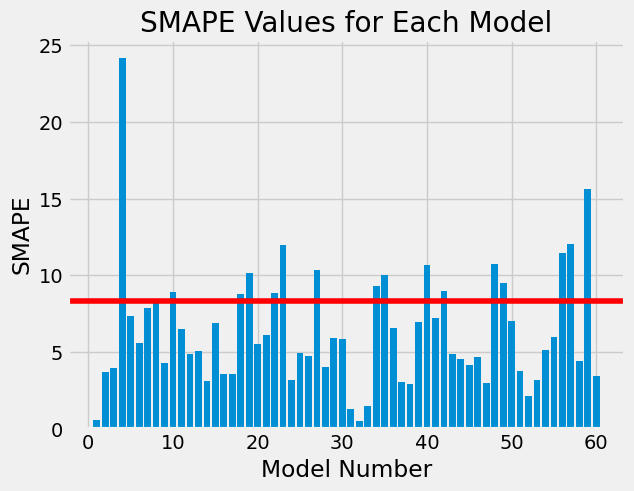

In [20]:
no_df = pd.DataFrame({'smape':method2_xgb_smape_scores})

plt.bar(np.arange(len(no_df))+1, no_df['smape'], label='SMAPE for each model')

plt.axhline(base_smape_scores, color = 'red', label=f'Base SMAPE: {round(base_smape_scores,2)}')

plt.xlabel('Model Number')  # 모델 번호
plt.ylabel('SMAPE')  # SMAPE 값
plt.title('SMAPE Values for Each Model')  # 그래프 제목
# plt.legend()
plt.show()

전체적으로, 많은 모델이 기존 모델 성능인 8.3보다 좋은 결과를 보였으나, __일부 모델은 성능이 저조하여 SMAPE 값이 20을 넘어가는 경우도 있었습니다.__ 이로 인해 전체 평균 SMAPE 값이 다소 높아졌습니다. 이는 일부 모델이 매우 높은 SMAPE 값을 기록하면서 평균이 왜곡된 결과를 초래한 것입니다.

그럼에도 불구하고, 대부분의 모델이 기존 모델보다 우수한 성능을 보였으며, 이러한 모델들은 성능을 개선하는 데 중요한 역할을 했습니다. SMAPE 값을 모델별로 세분화하여 분석함으로써, 성능이 좋지 않은 모델을 개선할 필요성과, 성능이 뛰어난 모델을 강조할 수 있었습니다.

### __후처리 (결과 시각화)__

성능이 좋은 모델의 예측

In [21]:
min_val = min(method2_xgb_smape_scores)

min_index =  method2_xgb_smape_scores.index(min_val) + 1

print(min_index)

32


SMAPE : 0.47555378915960445


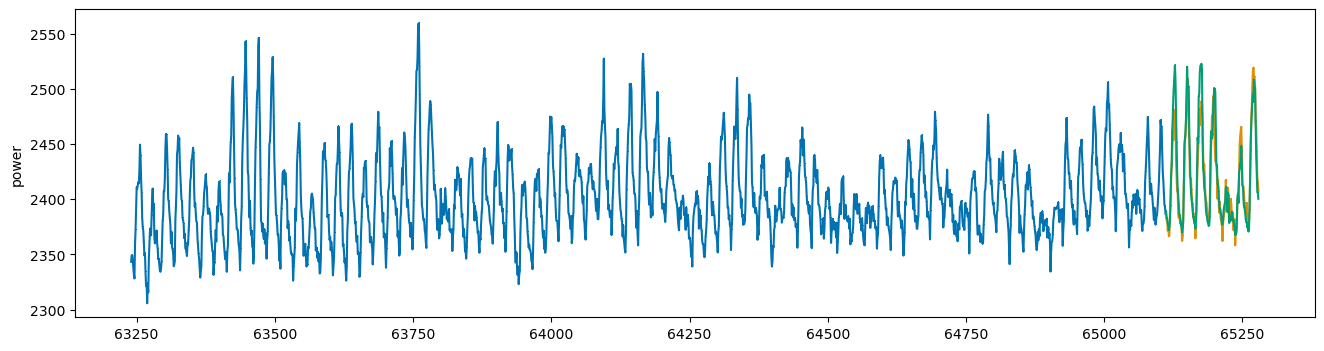

In [22]:
from sktime.utils.plotting import plot_series

x_train_num = x_train_final.loc[x_train_final.num == min_index].drop(['num','cluster'],axis=1,inplace=False)
y_train_num = y_train[x_train.num == min_index]

y_train_n, y_test_n, x_train_n, x_test_n = temporal_train_test_split(y = y_train_num,
                                                                          X = x_train_num, test_size = 24*7)

xgboost = xgb.XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.01, min_child_weight=3,
                               subsample=0.8, random_state=10, verbosity=0) 
xgboost.fit(x_train_n, y_train_n)


pred = xgboost.predict(x_test_n)
pred = pd.Series(pred)
pred.index = np.arange(y_test_n.index[0], y_test_n.index[-1]+1)

plt.style.use('default')  # 기본 스타일 적용
plt.rcParams['axes.facecolor'] = 'white'  # 배경 흰색 설정
plt.rcParams['savefig.facecolor'] = 'white'  # 저장 시 배경 흰색 설정

plot_series(y_train_n, y_test_n, pd.Series(pred), markers=[',' , ',', ','])

print('SMAPE : {}'.format(SMAPE(y_test_n, pred)))

성능이 가장 좋지 못한 모델의 예측

In [23]:
max_val = max(method2_xgb_smape_scores)

max_index =  method2_xgb_smape_scores.index(max_val) + 1
print(max_index)

4


SMAPE : 21.322581217292434


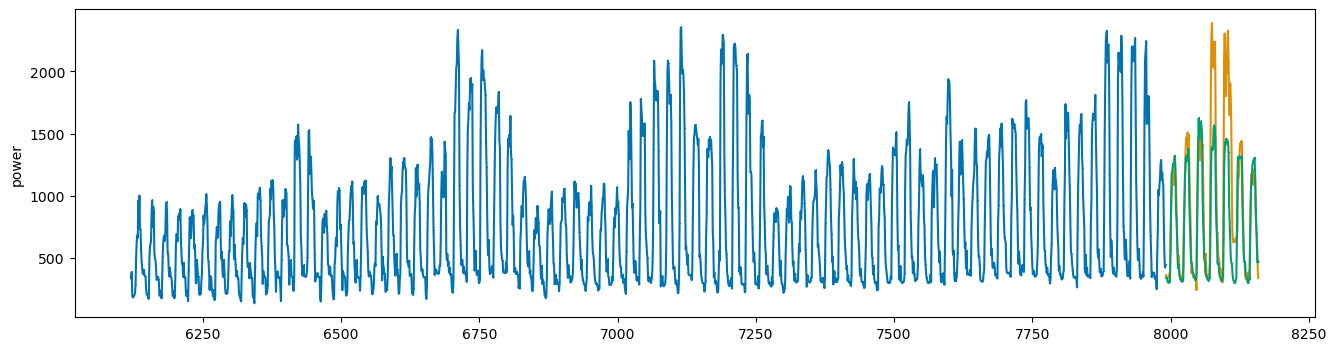

In [24]:
from sktime.utils.plotting import plot_series

x_train_num = x_train_final.loc[x_train_final.num == max_index].drop(['num','cluster'],axis=1,inplace=False)
y_train_num = y_train[x_train.num == max_index]

y_train_n, y_test_n, x_train_n, x_test_n = temporal_train_test_split(y = y_train_num,
                                                                          X = x_train_num, test_size = 24*7)

xgboost = xgb.XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.01, min_child_weight=3,
                               subsample=0.8, random_state=10, verbosity=0) 
xgboost.fit(x_train_n, y_train_n)

pred = xgboost.predict(x_test_n)
pred = pd.Series(pred)
pred.index = np.arange(y_test_n.index[0], y_test_n.index[-1]+1)


plt.style.use('default')  # 기본 스타일 적용
plt.rcParams['axes.facecolor'] = 'white'  # 배경 흰색 설정
plt.rcParams['savefig.facecolor'] = 'white'  # 저장 시 배경 흰색 설정

plot_series(y_train_n, y_test_n, pd.Series(pred), markers=[',' , ',', ','])

print('SMAPE : {}'.format(SMAPE(y_test_n, pred)))

위 그래프에서 파란색은 train 데이터의 전력사용량, 노란색은 val 데이터의 전력사용량, 초록색은 val 데이터의 전력사용량에 대한 예측값입니다.

성능이 가장 좋은 32번 건물에서는 예측값(초록색)이 실제값(노란색)과 거의 겹치는 모습을 보여 모델이 데이터를 잘 학습했음을 알 수 있습니다.

반면, 성능이 가장 좋지못했던 4번 건물에서는 예측값(초록색)이 실제값을 대체로 따라가며 주기적인 패턴을 어느 정도 학습해 반복적인 피크와 골을 잘 추정하는 모습을 보입니다. 그러나 값이 급격히 변동하는 구간에서 예측 성능이 저하되는 모습이 관찰됩니다.

### __인사이트__

__모델 성능 분석__

이번 분석에서 기존 모델과 군집별 모델, 건물번호(범주형변수)모델의 세가지 방법을 사용하여 모델을 학습하고 예측 성능을 비교했습니다. 그 결과, 군집별 모델과 건물번호별 모델 생성이 기존 모델보다 더 우수한 성능을 보였습니다. 이 분석을 통해 몇 가지 중요한 인사이트를 도출할 수 있었습니다.

1. 군집별 모델의 우수성

   
군집별로 모델을 학습하는 방식은 __데이터의 특성에 맞는 맞춤형 예측을 가능하게__ 했습니다. 각 군집에 맞는 모델을 학습함으로써, 데이터의 다양성을 더 잘 반영할 수 있었고, 그 결과 예측 성능이 기존 모델보다 향상되었습니다. 이는 데이터의 세분화된 특성을 고려하여 __모델이 더 정밀하게 학습__ 할 수 있기 때문입니다.

2. 범주형 변수별 모델의 성능 향상

   
범주형 변수인 건물 번호별로 60개 모델을 학습한 결과, 각 건물의 특성에 맞춰 모델을 최적화함으로써 예측 성능이 기존 모델보다 더 나은 결과를 보였습니다. 각 건물에 대한 세부적인 정보를 모델에 반영함으로써 __특정 건물에 맞는 예측을 더 정확하게 할 수__ 있었으며, 이는 SMAPE 값의 개선으로 이어졌습니다.

3. 모델 세분화의 중요성

   
군집별 및 범주형 변수별 모델의 성능 개선은 모델 세분화의 중요성을 강조합니다. __세분화된 모델이__ 각 데이터의 특성을 잘 반영할 수 있기 때문에 __더 정교하고 정확한 예측이__ 가능해졌습니다. 데이터의 특성에 따라 모델을 최적화하면, __예측 성능을 높일 수 있는 가능성이__ 커짐을 알 수 있습니다.

4. 향후 개선 방향
   
군집별 모델과 범주형 변수별 모델이 기존 모델보다 우수한 성능을 보였지만, __일부 모델에서 성능이 저조한 경우도__ 있었습니다. 이 문제를 해결하기 위해서는 모델의 세분화뿐만 아니라, __특성 선택 방법에__ 대한 추가적인 조정이 필요할 수 있습니다. 또한, 각 모델의 성능을 지속적으로 모니터링하고, __성능이 좋지 않은 모델을 개선하는 작업이__ 중요합니다.



## __최종 결론 및 제언__

__결론__

이번 작업의 핵심은 시계열 데이터의 특성을 이해하고 이를 효과적으로 반영하여 예측 성능을 극대화하는 데 있습니다.

* __Time Series split 방식은__ 각 건물의 독자적인 패턴을 학습하는 데 효과적이었으며, 많은 건물에서 예측값과 실제값의 차이가 없었고, 예측값과 실제값이 거의 일치하는 높은 성능을 보였습니다.

* 그러나 성능이 좋지 않았던 일부 건물(예: 4번 건물)에서는 예측값이 주기적인 패턴은 따라갔으나 급격한 변동 구간에서는 오차가 크게 발생했습니다. 이는 모델이 극단적인 변화나 특수한 패턴을 충분히 학습하지 못했음을 시사합니다.

* 또한, __방법1(군집화로 유사한 건물번호들을 그룹화한 후, 그룹을 별도의 모델로 분석)의 경우__, 기존 모델보다 예측 성능이 우수했습니다. 이는 유사한 패턴을 가진 건물들을 그룹화함으로써, 모델이 그룹 내 공통된 특성을 효과적으로 학습할 수 있었기 때문입니다. 이러한 접근법은  향후 다른 프로젝트에서 데이터의 패턴과 특성을 활용한 분석 및 모델링에 효과적으로 적용될 가능성이 높습니다.

__제언__

이번 분석을 바탕으로, 향후 예측 성능을 더욱 향상시키기 위한 몇 가지 방안도 함께 제안합니다. 

1. 순환 신경망(RNN, LSTM, GRU)이나 Transformer와 같은 시간 의존성을 잘 반영할 수 있는 모델을 도입하여 예측 성능을 더욱 향상시켜야 합니다.

2. Grid Search나 Bayesian Optimization과 같은 기법을 활용해 모델의 하이퍼파라미터를 최적화하고, 성능을 개선해야 합니다.

3. 예측 실패 사례를 집중 분석하여 급격한 변동의 원인을 파악하고, 이를 해결하기 위한 데이터 증강이나 추가 특징 반영을 고려해야 합니다.

이러한 전략들을 종합적으로 적용한다면, 데이터의 주기적인 패턴뿐만 아니라 급격한 변동 구간에서도 더욱 안정적이고 정확한 예측이 가능할 것입니다.